- MLR regression model
- independent variables GW abstraction, SW abstraction and P-PET0 from PCR-GLOBWB
- dependent variable from GRACE TWS

In [42]:
%reset -f
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import theilslopes
import scipy.ndimage
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

%matplotlib inline

In [43]:
#import data
Iwe_Grace = xr.open_mfdataset('/home/bauer013/ls/data/TELLUS_GRAC_L3_JPL_RL06_LND_v04_new/*.nc', engine='netcdf4', chunks=None)
Iwe_GraceFO  = xr.open_mfdataset('/home/bauer013/ls/data/TELLUS_GRFO_L3_JPL_RL06.1_LND_v04_new/*.nc', engine='netcdf4', chunks=None)
iwe_prcglob = xr.open_dataset('/scratch/bauer013/pcrglobwb_240528/global_merged/totalWaterStorageThickness_monthAvg_output.nc')

Precip_GLOBWB = xr.open_dataset('/scratch/bauer013/pcrglobwb_240528/global_merged/precipitation_annuaTot_output.nc')
PET_GLOBWB = xr.open_dataset('/scratch/bauer013/pcrglobwb_240528/input_files/pet_yearly_era5land-ulysses_05min_1981-2022_mperday.nc')
GWabstr_GLOBWB = xr.open_dataset('/scratch/bauer013/pcrglobwb_240528/global_merged/totalGroundwaterAbstraction_annuaTot_output.nc')
SWabstr_GLOBWB = xr.open_dataset('/scratch/bauer013/pcrglobwb_240528/global_merged/surfaceWaterAbstraction_annuaTot_output.nc')

temp_annual = xr.open_dataset('/scratch/bauer013/pcrglobwb_240528/global_merged/temperature_annuaAvg_output.nc')
ocean_mask = xr.open_dataset('/home/bauer013/ls/data/IMERG_land_sea_mask.nc')

In [44]:
#Preprocessing Grace data
# choose Lat and lon range
lon_min,lon_max = 60,349
lat_min,lat_max = 35,72

Iwe_Grace = Iwe_Grace.sel(lon=(Iwe_Grace['lon'] < lon_min) | (Iwe_Grace['lon'] >lon_max))
Iwe_Grace = Iwe_Grace.sel(lat=(Iwe_Grace['lat'] > lat_min) & (Iwe_Grace['lat'] < lat_max ))
Iwe_GraceFO = Iwe_GraceFO.sel(lon=(Iwe_GraceFO['lon'] < lon_min) | (Iwe_GraceFO['lon'] > lon_max))
Iwe_GraceFO = Iwe_GraceFO.sel(lat=(Iwe_GraceFO['lat'] > lat_min) & (Iwe_GraceFO['lat'] < lat_max))

annual_meanGRACE = Iwe_Grace.groupby('time.year').mean(dim='time')
annual_meanGRACE['lat'] = np.round(annual_meanGRACE['lat'], decimals=1)
annual_meanGRACE['lon'] = np.round(annual_meanGRACE['lon'], decimals=1)
annual_meanGRACEFO =  Iwe_GraceFO.groupby('time.year').mean(dim='time')

# combine Grace and GraceFO
combined_annual_mean = xr.concat([annual_meanGRACE, annual_meanGRACEFO], dim='year')
combined_annual_mean = combined_annual_mean.drop_sel(year=[2020,2021,2022,2023])
TWS_Grace  = combined_annual_mean[['lwe_thickness']]

# Match the lon and lat to GLOBWB
TWS_Grace['lon'] = (TWS_Grace['lon'] + 180) % 360 - 180
TWS_Grace['lon'] = np.concatenate([TWS_Grace['lon'].values[60:], TWS_Grace['lon'].values[:60]])
lwe_thickness_reordered = np.concatenate([TWS_Grace['lwe_thickness'].values[:, 60:], TWS_Grace['lwe_thickness'].values[:, :60]], axis=1)
lwe_thickness_da = xr.DataArray(lwe_thickness_reordered, dims=('year', 'lat', 'lon'), coords={'lat': TWS_Grace['lat'], 'lon': TWS_Grace['lon']})
TWS_Grace['lwe_thickness'] = lwe_thickness_da
TWS_Grace = TWS_Grace.sortby('lat', ascending=False)

# Apply normalization to the TWS_Grace variable
def normalize(data):
    mean = data.mean()
    std = data.std()
    return (data - mean) / std
TWS_Grace = normalize(TWS_Grace)

In [45]:
#ocean and temperture mask
#ocean mask fata from https://gpm.nasa.gov/data/directory/imerg-land-sea-mask-netcdf 23.04.2024
ocean_mask = ocean_mask.sel(lon=slice(0, 360))
ocean_mask = ocean_mask.sel(lon=(ocean_mask['lon'] < 60) | (ocean_mask['lon'] > 349))
ocean_mask = ocean_mask.sel(lat=(ocean_mask['lat'] > 35) & (ocean_mask['lat'] < 72 ))
ocean_mask = ocean_mask.coarsen(lon=10, lat=10).mean()
ocean_mask['lon'] = (ocean_mask['lon'] + 180) % 360 - 180
ocean_mask['lon'] = np.concatenate([ocean_mask['lon'].values[60:], ocean_mask['lon'].values[:60]])
slope_reordered = np.concatenate([ocean_mask['landseamask'].values[:, 60:], ocean_mask['landseamask'].values[:, :60]], axis=1)
ocean_mask['landseamask'] = xr.DataArray(slope_reordered, dims=('lat', 'lon'), coords={'lat': ocean_mask['lat'], 'lon': ocean_mask['lon']})
ocean_mask  = ocean_mask.expand_dims({'time': Precip_GLOBWB.time}, axis=0)
ocean_mask = ocean_mask.groupby('time.year').mean(dim='time')
ocean_mask = ocean_mask.sel(year=slice(2002, None))
ocean_mask = ocean_mask.drop_sel(year=[2020,2021,2022])

# adjust parameter. Which percentage needs to be water
ocean_mask = ocean_mask['landseamask'] > 75 # Typical percentage thresholds used to define sea are 100% (strictly open water) or 75% (including sea-ward coast areas)
ocean_mask['lat'] = np.round(ocean_mask['lat'], decimals=1)
ocean_mask['lon'] = np.round(ocean_mask['lon'], decimals=1)
ocean_mask = ocean_mask.sortby('lat', ascending=False)

#Temperture Mask
#taking lat/lon 
temp_annual = temp_annual.rename({'latitude': 'lat'})
temp_annual = temp_annual.rename({'longitude': 'lon'})
temp_annual = temp_annual.sel(lon=(temp_annual['lon'] < 60) & (temp_annual['lon'] > -11)) 
temp_annual = temp_annual.sel(lat=(temp_annual['lat'] > 35) & (temp_annual['lat'] < 72))
#adjust if mean cell temperture or min cell temperture is selected
temp_mean = temp_annual.mean(dim='time', keep_attrs=True)
temp_mean  = temp_mean.expand_dims({'time': temp_annual.time}, axis=0)
temp_mean = temp_mean.groupby('time.year').mean(dim='time')
temp_mean = temp_mean.sel(year=slice(2002, None))
temp_mean = temp_mean.drop_sel(year=[2020,2021,2022])
temp_mask = temp_mean['temperature'] < 0 
temp_mask['lat'] = np.round(temp_mask['lat'], decimals=2)
temp_mask['lon'] = np.round(temp_mask['lon'], decimals=2)

In [46]:
#Preprocessing GLOBWB data
PET_GLOBWB = PET_GLOBWB.drop_vars('time_bnds')
PET_GLOBWB = PET_GLOBWB.rename({'lat' : 'latitude'})
PET_GLOBWB = PET_GLOBWB.rename({'lon' : 'longitude'})
GLOBWB = {}
GLOBWB['Precip_GLOBWB'] = Precip_GLOBWB
GLOBWB['PET_GLOBWB'] = PET_GLOBWB
GLOBWB['GWabstr_GLOBWB'] = GWabstr_GLOBWB
GLOBWB['SWabstr_GLOBWB'] = SWabstr_GLOBWB
window_size = 5

for var_name, dataset in GLOBWB.items():
    GLOBWB[var_name] = GLOBWB[var_name].rename({'latitude': 'lat'})
    GLOBWB[var_name] = GLOBWB[var_name].rename({'longitude': 'lon'})
    GLOBWB[var_name] = GLOBWB[var_name].sel(lon=(GLOBWB[var_name]['lon'] < 60) & (GLOBWB[var_name]['lon'] > -11)) 
    GLOBWB[var_name] = GLOBWB[var_name].sel(lat=(GLOBWB[var_name]['lat'] > 35) & (GLOBWB[var_name]['lat'] < 72))
    GLOBWB[var_name] = GLOBWB[var_name].groupby('time.year').mean(dim='time')
    GLOBWB[var_name] = GLOBWB[var_name].sel(year=slice(2002, None))
    GLOBWB[var_name] = GLOBWB[var_name].drop_sel(year=[2020,2021,2022])
    GLOBWB[var_name]['lat'] = np.round(GLOBWB[var_name]['lat'], decimals=2)
    GLOBWB[var_name]['lon'] = np.round(GLOBWB[var_name]['lon'], decimals=2)
    GLOBWB[var_name] = GLOBWB[var_name].where(~temp_mask, np.nan)
    GLOBWB[var_name] = GLOBWB[var_name].coarsen(lon=12, lat=12).mean()
    GLOBWB[var_name]['lat'] = np.round(GLOBWB[var_name]['lat'], decimals=1)
    GLOBWB[var_name]['lon'] = np.round(GLOBWB[var_name]['lon'], decimals=1)
    GLOBWB[var_name] = GLOBWB[var_name].where(~ocean_mask, np.nan)
    GLOBWB[var_name] = GLOBWB[var_name].rolling(lon=window_size, lat=window_size, center=True, min_periods=15).mean()
    GLOBWB[var_name] = GLOBWB[var_name].where(~ocean_mask, np.nan)

Precip_GLOBWB = GLOBWB['Precip_GLOBWB']
PET_GLOBWB = GLOBWB['PET_GLOBWB']
GWabstr_GLOBWB = GLOBWB['GWabstr_GLOBWB']
SWabstr_GLOBWB = GLOBWB['SWabstr_GLOBWB']

P_PET_GLOBWB = Precip_GLOBWB
P_PET_GLOBWB = P_PET_GLOBWB.rename_vars({'precipitation': 'PminusPET'})
P_PET_GLOBWB['PminusPET'] = Precip_GLOBWB['precipitation'] - PET_GLOBWB['pet']

#normalize data 
GWabstr_GLOBWB = normalize(GWabstr_GLOBWB)
SWabstr_GLOBWB = normalize(SWabstr_GLOBWB)
P_PET_GLOBWB = normalize(P_PET_GLOBWB)

In [47]:
#creating new dataset
lon_range = GWabstr_GLOBWB['lon'].values 
lat_range = GWabstr_GLOBWB['lat'].values

MLR_params = xr.Dataset(
    {'Slope_PminusPET': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'pvalue_PminusPET': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'Slope_GW_abstr': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'pvalue_GW_abstr': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'Slope_SW_abstr': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'pvalue_SW_abstr': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'Intercept': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'rsquared': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'rsquared_adj': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'f_pvalue': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range))))},
    coords={'lat': lat_range, 'lon': lon_range},
)

LR_params = xr.Dataset(
    {'Slope_PminusPET': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'Slope_GW_abstr': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'Slope_SW_abstr': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'rsquared_PminusPET': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'rsquared_GW_abstr': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'rsquared_SW_abstr': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'f_pvalue_PminusPET': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'f_pvalue_GW_abstr': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'f_pvalue_SW_abstr': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range))))},
    coords={'lat': lat_range, 'lon': lon_range}
)


In [48]:
# making multivariante linear regression
for lon in lon_range:
  for lat in lat_range:
    independent_vars = [
    GWabstr_GLOBWB['total_groundwater_abstraction'].sel(lon=lon, lat=lat, method='nearest'),
    SWabstr_GLOBWB['surface_water_abstraction'].sel(lon=lon, lat=lat, method='nearest'),
    P_PET_GLOBWB['PminusPET'].sel(lon=lon, lat=lat, method='nearest')
    ]
    X = xr.merge(independent_vars).drop(['lon', 'lat']).to_dataframe()
    X['const'] = 1 
    dependent_var = [
    TWS_Grace['lwe_thickness'].sel(lon=lon, lat=lat, method='nearest')
    ]
    y = xr.merge(dependent_var).drop(['lon', 'lat']).to_dataframe()
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    if X.PminusPET.isna().any() | y.lwe_thickness.isna().any():
     MLR_params['Slope_PminusPET'].loc[{'lat': lat, 'lon': lon}] = np.nan
     MLR_params['pvalue_PminusPET'].loc[{'lat': lat, 'lon': lon}] = np.nan
     MLR_params['Slope_GW_abstr'].loc[{'lat': lat, 'lon': lon}] = np.nan
     MLR_params['pvalue_GW_abstr'].loc[{'lat': lat, 'lon': lon}] = np.nan
     MLR_params['Slope_SW_abstr'].loc[{'lat': lat, 'lon': lon}] = np.nan
     MLR_params['pvalue_SW_abstr'].loc[{'lat': lat, 'lon': lon}] = np.nan
     MLR_params['Intercept'].loc[{'lat': lat, 'lon': lon}] = np.nan
     MLR_params['rsquared'].loc[{'lat': lat, 'lon': lon}] = np.nan
     MLR_params['rsquared_adj'].loc[{'lat': lat, 'lon': lon}] = np.nan
     MLR_params['f_pvalue'].loc[{'lat': lat, 'lon': lon}] = np.nan
    else:
     model = sm.OLS(y, X, missing='drop', hasconst=False).fit()
     MLR_params['Slope_PminusPET'].loc[{'lat': lat, 'lon': lon}] = model.params.PminusPET
     MLR_params['pvalue_PminusPET'].loc[{'lat': lat, 'lon': lon}] = model.pvalues.PminusPET
     MLR_params['Slope_GW_abstr'].loc[{'lat': lat, 'lon': lon}] = model.params.total_groundwater_abstraction
     MLR_params['pvalue_GW_abstr'].loc[{'lat': lat, 'lon': lon}] = model.pvalues.total_groundwater_abstraction
     MLR_params['Slope_SW_abstr'].loc[{'lat': lat, 'lon': lon}] = model.params.surface_water_abstraction 
     MLR_params['pvalue_SW_abstr'].loc[{'lat': lat, 'lon': lon}] = model.pvalues.surface_water_abstraction 
     MLR_params['Intercept'].loc[{'lat': lat, 'lon': lon}] = model.params.const
     MLR_params['rsquared'].loc[{'lat': lat, 'lon': lon}] = model.rsquared
     MLR_params['rsquared_adj'].loc[{'lat': lat, 'lon': lon}] = model.rsquared_adj
     MLR_params['f_pvalue'].loc[{'lat': lat, 'lon': lon}] = model.f_pvalue


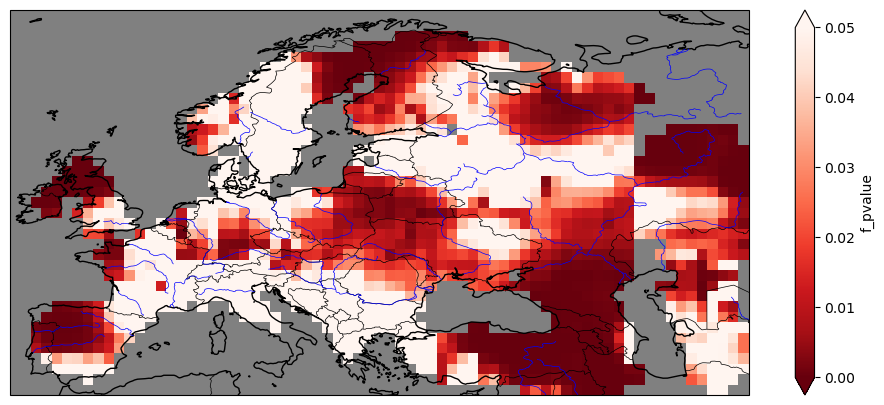

In [49]:
#plot pvalue
pvalue = MLR_params['f_pvalue'].values
lon , lat = MLR_params['lon'].values, MLR_params['lat'].values #set lat and lon
vmin, vmax = 0, 0.05 #set color ranges

fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('Reds')
cmap = cmap.reversed()

c = ax.pcolormesh(lon , lat, pvalue, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), shading='auto')
cmap.set_bad(color='grey', alpha=1.0) 
# Add coastlines for reference
ax.coastlines()
countries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', edgecolor='black', facecolor='none')
rivers = NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', edgecolor='blue', facecolor='none')
ax.add_feature(countries, linestyle='-', linewidth=0.5)
ax.add_feature(rivers, linestyle='-', linewidth=0.5)
cbar = plt.colorbar(c, ax=ax, extend='both', orientation='vertical')
cbar.set_label('f_pvalue')
 
# Show the plot
plt.show()

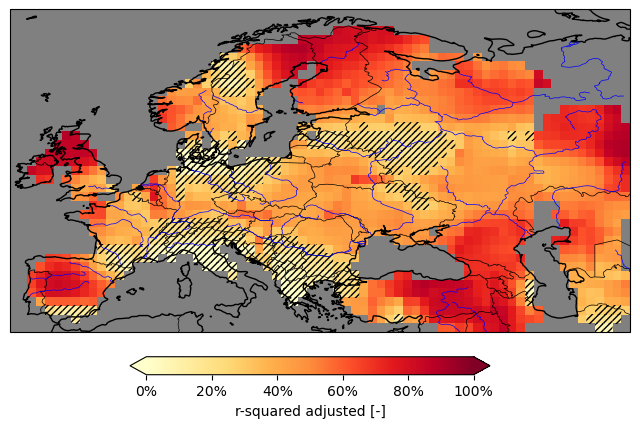

In [38]:
#plot rsquared with hatched insignificant values

rsquared =  MLR_params['rsquared_adj'].values
lon , lat = MLR_params['lon'].values, MLR_params['lat'].values
pvalue_mask = np.ma.masked_less(MLR_params['f_pvalue'].values, 0.05)

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('YlOrRd')
# Set the range for colors
vmin, vmax = 0, 1
# Plot the slope without normalization
c = ax.pcolormesh(lon , lat, rsquared, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), shading='auto')
plt.pcolor(lon , lat, pvalue_mask, hatch='/////', alpha=0)

cmap.set_bad(color='grey', alpha=1) 
# Add coastlines for reference
ax.coastlines()
countries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', edgecolor='black', facecolor='none')
rivers = NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', edgecolor='blue', facecolor='none')
ax.add_feature(countries, linestyle='-', linewidth=0.5)
ax.add_feature(rivers, linestyle='-', linewidth=0.5)

# Add colorbar with vmin and vmax
cbar = plt.colorbar(c, ax=ax, extend='both', orientation='horizontal')
# Define the formatter to convert ticks to percentages
cbar.formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.0%}')
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0%}'))
cbar.ax.set_position([0.2, 0.27, 0.6, 0.03]) 
cbar.set_label('r-squared adjusted [-]')
 
# Show the plot
plt.show()

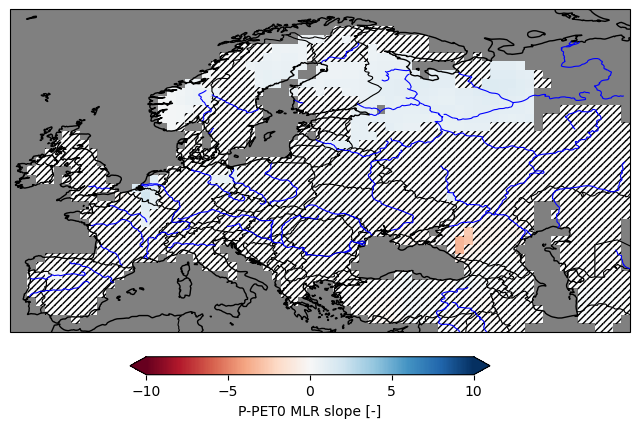

In [35]:
#plot slopes of MLR
Slope =  MLR_params['Slope_PminusPET'].values
pvalue =  MLR_params['pvalue_PminusPET'].values
lon , lat = MLR_params['lon'].values, MLR_params['lat'].values
pvalue_mask = np.ma.masked_less(pvalue, 0.05)
pvalue_mask_alpha = np.ma.masked_where(np.isnan(pvalue) | (pvalue <= 0.05), pvalue)
vmin, vmax = -10, 10 # Set the range for colors
alpha = np.where(pvalue_mask_alpha.mask, 1, 0.2)

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('RdBu_r')
cmap = cmap.reversed()
c = ax.pcolormesh(lon , lat, Slope, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), shading='auto', alpha=alpha)
plt.pcolor(lon , lat, pvalue_mask, hatch='/////', alpha=0)
cmap.set_bad(color='grey', alpha=1) 
# Add coastlines for reference
ax.coastlines()
countries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', edgecolor='black', facecolor='none')
rivers = NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', edgecolor='blue', facecolor='none')
ax.add_feature(countries, linestyle='-', linewidth=0.8)
ax.add_feature(rivers, linestyle='-', linewidth=0.8)
# Add colorbar with vmin and vmax
cbar = plt.colorbar(c, ax=ax, extend='both', orientation='horizontal')
cbar.ax.set_position([0.2, 0.27, 0.6, 0.03]) 
cbar.set_label('P-PET0 MLR slope [-]')
cbar.ax.set_position([0.2, 0.27, 0.6, 0.03]) 
# Show the plot
plt.show()

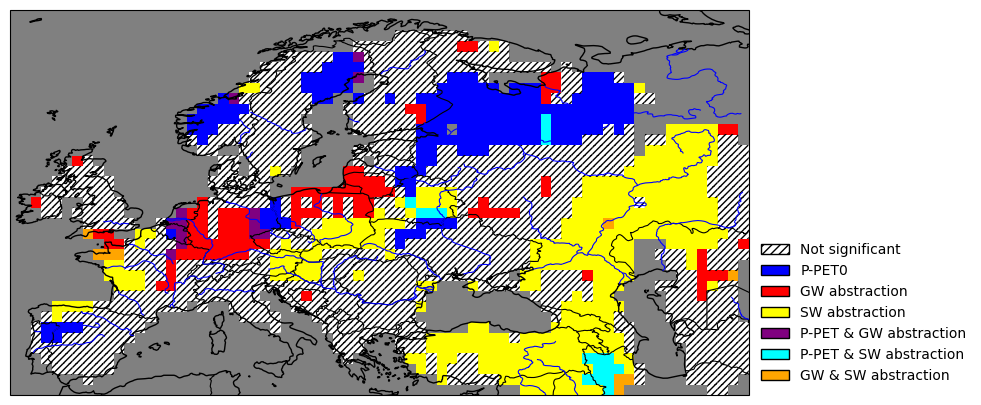

In [51]:
#plot all SLope paramater
pvalue = MLR_params['f_pvalue'].values
lon , lat = MLR_params['lon'].values, MLR_params['lat'].values #set lat and lon

PminusPET_pvalue_mask = np.ma.masked_less(MLR_params['pvalue_PminusPET'].values, 0.05)
GW_slope_mask = MLR_params['Slope_GW_abstr'].values < 0
GW_abstr_pvalue_mask = np.ma.masked_less(MLR_params['pvalue_GW_abstr'].values, 0.05)
GW_combined_mask = np.logical_and(GW_abstr_pvalue_mask.mask, GW_slope_mask)
GW_abstr_pvalue_mask_final = np.ma.masked_array(MLR_params['pvalue_GW_abstr'].values, GW_combined_mask)
SW_slope_mask = MLR_params['Slope_SW_abstr'].values < 0
SW_abstr_pvalue_mask = np.ma.masked_less(MLR_params['pvalue_SW_abstr'].values, 0.05)
SW_combined_mask = np.logical_and(SW_abstr_pvalue_mask.mask, SW_slope_mask)
SW_abstr_pvalue_mask_final = np.ma.masked_array(MLR_params['pvalue_SW_abstr'].values, SW_combined_mask)

par_significance = np.zeros_like(MLR_params['Slope_SW_abstr'].values)

# Assign different values based on the masks
par_significance[~PminusPET_pvalue_mask.mask & ~SW_abstr_pvalue_mask_final.mask & ~GW_abstr_pvalue_mask_final.mask ] = 0
par_significance[PminusPET_pvalue_mask.mask] = 1
par_significance[GW_abstr_pvalue_mask_final.mask] = 2
par_significance[SW_abstr_pvalue_mask_final.mask] = 3
par_significance[PminusPET_pvalue_mask.mask & GW_abstr_pvalue_mask_final.mask] = 4 
par_significance[PminusPET_pvalue_mask.mask & SW_abstr_pvalue_mask_final.mask] = 5 
par_significance[SW_abstr_pvalue_mask_final.mask & GW_abstr_pvalue_mask_final.mask] = 6
par_significance[np.isnan(pvalue)] = np.nan

pvalue_mask_alpha = np.ma.masked_where((par_significance != 0), par_significance)
alpha = np.where(pvalue_mask_alpha.mask, 1, 0.2)
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Define colormap
custom_colors = ['#FFFFFF', '#0000FF', '#FF0000', '#FFFF00', '#800080', '#00FFFF', '#FFA500']

# Create a ListedColormap using the custom colors
custom_cmap = mcolors.ListedColormap(custom_colors, name='custom_cmap')

# Plot the significance map
pcm = ax.pcolormesh(lon , lat, par_significance, cmap=custom_cmap, transform=ccrs.PlateCarree(), alpha=alpha)

plt.pcolor(lon , lat, pvalue_mask_alpha, hatch='/////', alpha=0)
custom_cmap.set_bad(color='grey', alpha=1)
# Add coastlines for reference
ax.coastlines()
countries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', edgecolor='black', facecolor='none')
rivers = NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', edgecolor='blue', facecolor='none')
ax.add_feature(countries, linestyle='-', linewidth=0.8)
ax.add_feature(rivers, linestyle='-', linewidth=0.8)

# Add colorbar
legend_handles = []
legend_labels = ['Not significant', 'P-PET0', 'GW abstraction', 'SW abstraction', 'P-PET & GW abstraction', 'P-PET & SW abstraction', 'GW & SW abstraction']
for i, label in enumerate(legend_labels):
    patch = mpatches.Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=custom_cmap(i), linewidth=1, label=label, fill=True)
    if i == 0:
        patch = mpatches.Rectangle((0, 0), 1, 1, edgecolor='black', linewidth=1, label=label, fill=False)
        patch.set_hatch('////') 
    legend_handles.append(patch)
# Add legend with corresponding colors
#ax.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0, -0.15), framealpha=0, ncol = 4)
ax.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(1,0), framealpha=0)

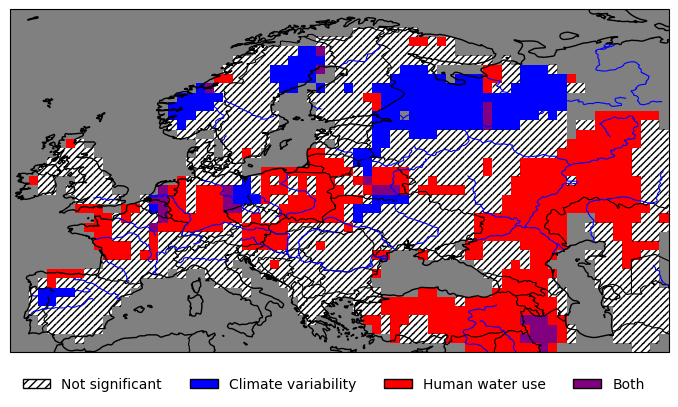

In [15]:
#Natural climate variablity, Human water use (GW abstr, SW abstr), Human induced climate change.

Climate_induced = np.ma.masked_less(MLR_params['pvalue_PminusPET'].values, 0.05)
GW_slope_mask = MLR_params['Slope_GW_abstr'].values < 0
GW_abstr_pvalue_mask = np.ma.masked_less(MLR_params['pvalue_GW_abstr'].values, 0.05)
SW_slope_mask = MLR_params['Slope_SW_abstr'].values < 0
SW_abstr_pvalue_mask = np.ma.masked_less(MLR_params['pvalue_SW_abstr'].values, 0.05)
GW_water_use = np.logical_and(GW_abstr_pvalue_mask.mask, GW_slope_mask)
SW_water_use = np.logical_and(SW_abstr_pvalue_mask.mask, SW_slope_mask)
human_water_use = np.logical_or(GW_water_use, SW_water_use)
par_significance = np.zeros_like(MLR_params['Slope_GW_abstr'].values)

# Assign different values based on the masks
par_significance[~human_water_use & ~Climate_induced.mask] = 1
par_significance[Climate_induced.mask] = 2
par_significance[human_water_use] = 3
par_significance[human_water_use & Climate_induced.mask] = 4
par_significance[np.isnan(pvalue)] = np.nan


pvalue_mask_alpha = np.ma.masked_where((par_significance != 1), par_significance)
alpha = np.where(pvalue_mask_alpha.mask, 1, 0.2)


fig, ax = plt.subplots(figsize=(8.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Define colormap
custom_colors = ['#FFFFFF', '#0000FF', '#FF0000', '#800080']

# Create a ListedColormap using the custom colors
custom_cmap = mcolors.ListedColormap(custom_colors, name='custom_cmap')

# Plot the significance map
pcm = ax.pcolormesh(MLR_params['lon'], MLR_params['lat'], par_significance, cmap=custom_cmap, transform=ccrs.PlateCarree(), alpha=alpha)
plt.pcolor(lon , lat, pvalue_mask_alpha, hatch='/////', alpha=0)
custom_cmap.set_bad(color='grey', alpha=1)
# Add coastlines for reference
ax.coastlines()
countries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', edgecolor='black', facecolor='none')
rivers = NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', edgecolor='blue', facecolor='none')
ax.add_feature(countries, linestyle='-', linewidth=0.8)
ax.add_feature(rivers, linestyle='-', linewidth=0.8)

# Add colorbar
legend_handles = []
legend_labels = ['Not significant', 'Climate variability', 'Human water use', 'Both']

for i, label in enumerate(legend_labels):
    patch = mpatches.Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=custom_cmap(i), linewidth=1, label=label, fill=True)
    if i == 0:
        patch = mpatches.Rectangle((0, 0), 1, 1, edgecolor='black', linewidth=1, label=label, fill=False)
        patch.set_hatch('////') 
    legend_handles.append(patch)
# Add legend with corresponding colors
ax.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0, -0.15), framealpha=0, ncol = 4)
